In [2]:
from stardist.models import StarDist3D
import numpy as np
import pandas as pd
import napari
from skimage.segmentation import relabel_sequential
from tifffile import imread
from stardist.matching import matching, matching_dataset, group_matching_labels
from tqdm import tqdm
from skimage.segmentation import relabel_sequential
import statistics
from skimage.filters import gaussian
from skimage.segmentation import watershed
from skimage.measure import regionprops
from skimage import morphology

import sys
import os
from pathlib import Path

cwd = os.getcwd()
# print(f"Working dir: {cwd}")
module_path = os.path.abspath(Path(cwd).parents[2])
# print(f"Module dir: {module_path}")
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.data.preprocess_utils import load_files, resample_crop_downsample
from src.models.stardist3D import stardist_predict, threshold_optimization
from src.evaluation.evaluate_models import get_boundary_based_metrics_per_object
from src.visualization.visualize import plot_matching_dataset_results, plot_confusion_matrix
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set_palette("Set2")

In [3]:
Path("metrics").mkdir(parents=True, exist_ok=True)   # create dir to save figures
#Path(os.path.join(module_path, "reports", "figures", "stardist", "trained_on_pmaps")).mkdir(parents=True, exist_ok=True)   # create dir to save figures
#Path(os.path.join(module_path, "notebooks", "results", "Stardist", "trained_on_pmaps", "metrics")).mkdir(parents=True, exist_ok=True)   # create dir to save metrics

exp_dir = os.path.join(module_path, "experiments", "exp17")

In [3]:
raw = load_files(os.path.join(module_path, "data", "stardist_train_val_test_2022-08-17", "test", "raw_normalized"))

Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\data\stardist_train_val_test_2022-08-17\test\raw_normalized


In [18]:
predictions44 = load_files(os.path.join(exp_dir, "results"))
predictions44[0].shape

Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\experiments\exp17\results


(288, 288, 288)

In [8]:
y_true = load_files(os.path.join(module_path, "data", "matched_test_set", "isotropic"))

Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\data\matched_test_set\isotropic


In [9]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]   # different threshold values for pred to be considered a tp

### Seeds are centroids

In [10]:
metrics_multi_thres = [matching_dataset(np.array(y_true).astype("int32"), np.array(predictions44).astype("int32"), thresh=t, show_progress=False) for t in tqdm(taus)]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [05:54<00:00, 39.41s/it]


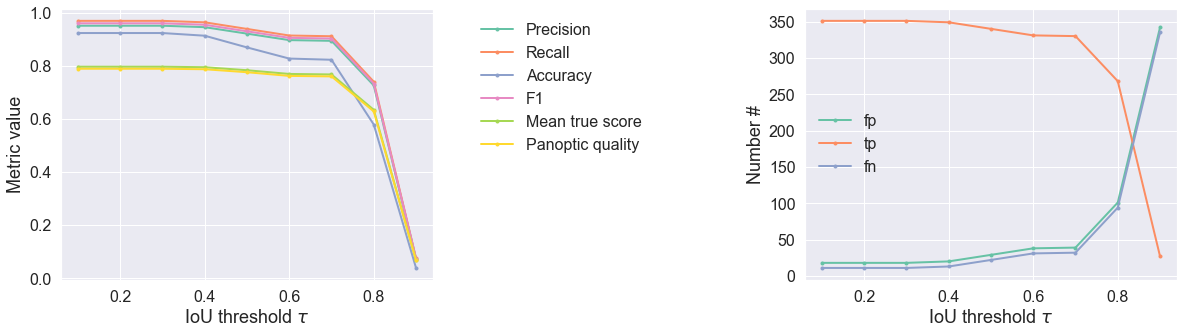

In [11]:
plot_matching_dataset_results(metrics_multi_thres, taus, save_dir=os.path.join(module_path, "reports", "figures", "watershed", "exp17_seeds_from_star_wt.png"))

In [13]:
metrics_multi_thres[2]

DatasetMatching(criterion='iou', thresh=0.3, fp=18, tp=351, fn=11, precision=0.9512195121951219, recall=0.9696132596685083, accuracy=0.9236842105263158, f1=0.960328317373461, n_true=362, n_pred=369, mean_true_score=0.7967729087692598, mean_matched_score=0.8217429999272707, panoptic_quality=0.7891430724335761, by_image=False)

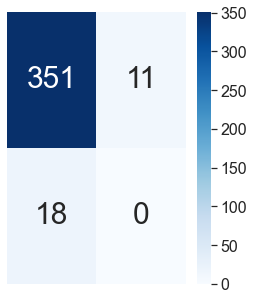

In [15]:
plot_confusion_matrix(metrics_multi_thres, taus, thres=0.3, save_dir = os.path.join(module_path, "reports", "figures", "watershed", "exp17_seeds_from_star_centroids_wt_cm.png"))

### Seeds are eroded by 4 pixels StarDist prediction

In [19]:
metrics_multi_thres = [matching_dataset(np.array(y_true).astype("int32"), np.array(predictions44).astype("int32"), thresh=t, show_progress=False) for t in tqdm(taus)]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [06:06<00:00, 40.72s/it]


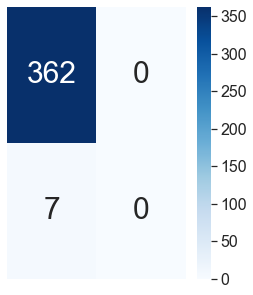

In [21]:
plot_confusion_matrix(metrics_multi_thres, taus, thres=0.3, save_dir = os.path.join(module_path, "reports", "figures", "watershed", "exp17_seeds_from_star_wt_cm.png"))

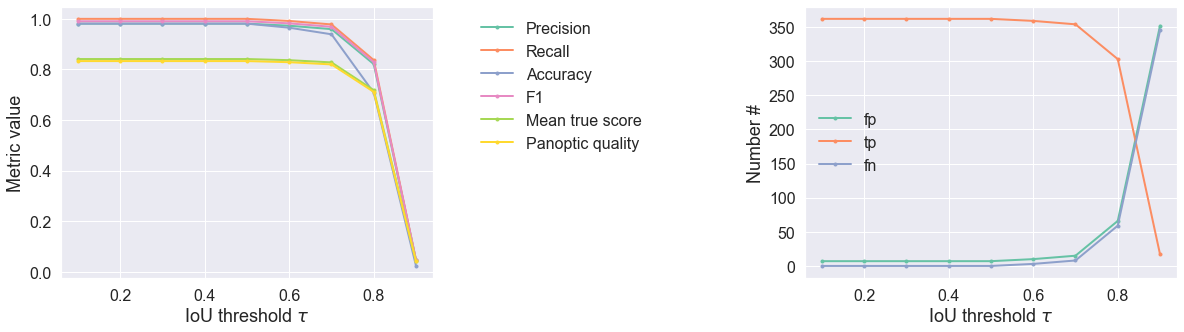

In [22]:
plot_matching_dataset_results(metrics_multi_thres, taus, save_dir=os.path.join(module_path, "reports", "figures", "watershed", "exp17_seededwt_whole_star_as_seed.png"))

## Boundary based metrics

In [23]:
res_df = get_boundary_based_metrics_per_object(predictions44, y_true, spacing_mm = (0.000173, 0.000173, 0.000173), hausdorff_percent=95.0, tolerance_mm=0.000173*3)   # tolerance is 3 pixels


Computing surface distances dict for each label:   0%|                                          | 0/35 [00:00<?, ?it/s]
Computing surface distances dict for each label:   3%|▉                                 | 1/35 [00:04<02:19,  4.11s/it]
Computing surface distances dict for each label:   6%|█▉                                | 2/35 [00:08<02:18,  4.20s/it]
Computing surface distances dict for each label:   9%|██▉                               | 3/35 [00:12<02:19,  4.36s/it]
Computing surface distances dict for each label: 100%|█████████████████████████████████| 35/35 [05:38<00:00,  9.68s/it]
metrics.py (317): invalid value encountered in double_scalars
metrics.py (319): invalid value encountered in double_scalars
metrics.py (388): invalid value encountered in double_scalars
metrics.py (391): invalid value encountered in double_scalars
metrics.py (421): invalid value encountered in double_scalars


In [24]:
pd.set_option('display.max_rows', res_df.shape[0]+1)
res_df_wo_nans= res_df.dropna(subset=["DSCvol", "surf_overlap_of_pred_surf_w_gt_surf"])

In [25]:
final = res_df_wo_nans.reset_index(drop=True)
final

,avrg_d_from_gt_to_pred,avrg_d_from_pred_to_gt,HD95,surf_overlap_of_gt_surf_w_pred_surf,surf_overlap_of_pred_surf_w_gt_surf,DSCsurf,DSCvol
0,0.383041,0.364898,0.733977,0.738087,0.785911,0.760568,0.882166
1,0.351481,0.350670,0.733977,0.751235,0.768324,0.759441,0.894288
2,0.306001,0.276865,0.733977,0.802506,0.865978,0.832018,0.912534
3,0.305473,0.269489,0.713297,0.796238,0.866512,0.828727,0.913003
4,0.349563,0.324421,0.733977,0.798910,0.871722,0.833156,0.894402
5,0.321700,0.320769,0.713297,0.808925,0.838114,0.822735,0.906675
6,0.292813,0.262109,0.713297,0.851040,0.924156,0.884884,0.919813
7,0.316001,0.278524,0.713297,0.784600,0.866349,0.822710,0.917269
8,0.332937,0.307069,0.713297,0.836798,0.905257,0.868550,0.899776
9,0.272769,0.267209,0.692000,0.878041,0.902279,0.889533,0.919643


In [27]:
final.to_csv(r"metrics/exp17_distance_metrics_df.csv")

In [29]:
metrics_combined = {
    'Mean distance from the GT to predicted surface in microns': final["avrg_d_from_gt_to_pred"].mean(),
    "Mean distance from predicted to the GT surface in microns": final["avrg_d_from_pred_to_gt"].mean(),
    "Mean Hausdorff95 distance": final["HD95"].mean(),
    "Mean surface overlap fraction of GT surfaces with predicted surfaces": final["surf_overlap_of_gt_surf_w_pred_surf"].mean(),
    "Mean surface overlap fraction of the predicted surfaces with the GT surfaces": final["surf_overlap_of_pred_surf_w_gt_surf"].mean(),
    "Mean surface DSC": final["DSCsurf"].mean(),
    "Mean volume DSC over matched objects": final["DSCvol"].mean(),
}

for m in ('tp', 'fn', 'fp', "precision", "recall", "accuracy", "f1", "mean_true_score", "mean_matched_score", "panoptic_quality"):
    metrics_combined[m] = metrics_multi_thres[2]._asdict()[m]
metrics_combined

{'Mean distance from the GT to predicted surface in microns': 0.320881877210294,
 'Mean distance from predicted to the GT surface in microns': 0.30087953660271793,
 'Mean Hausdorff95 distance': 1.0082449744105995,
 'Mean surface overlap fraction of GT surfaces with predicted surfaces': 0.8477872158869987,
 'Mean surface overlap fraction of the predicted surfaces with the GT surfaces': 0.8849869917907666,
 'Mean surface DSC': 0.8645608158562565,
 'Mean volume DSC over matched objects': 0.912784834479474,
 'tp': 362,
 'fn': 0,
 'fp': 7,
 'precision': 0.981029810298103,
 'recall': 1.0,
 'accuracy': 0.981029810298103,
 'f1': 0.9904240766073872,
 'mean_true_score': 0.8412310760982787,
 'mean_matched_score': 0.8412310760982787,
 'panoptic_quality': 0.8331755117580764}

In [30]:
import json

with open("metrics/exp17_metrics.json", "w") as f:
    json.dump(metrics_combined, f) 